In [123]:
%%javascript
// Run for table of contents.
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// https://github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

# Tests with NIPS data

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>


In [231]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from imp import reload
from pprint import pprint

import logging

from gensim.models import AtVb
from gensim.models import atvb
from gensim.models import OnlineAtVb
from gensim.models import onlineatvb

from time import time

%matplotlib inline

In [3]:
# Configure logging.

#log_dir = '../../../log_files/log.log'  # On my own machine.
log_dir = '../../../../log_files/log.log'  # On Hetzner

logger = logging.getLogger()
fhandler = logging.FileHandler(filename=log_dir, mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

## Load and prepare data structure

In [247]:
import os
import re

# Folder containing all NIPS papers.
#data_dir = '../../../../data/nipstxt/'  # On my own machine.
data_dir = '../../../nipstxt/'  # On Hetzner.

# Folders containin individual NIPS papers.
yrs = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
#yrs = ['00']
dirs = ['nips' + yr for yr in yrs]

# Get all document texts and their corresponding IDs.
docs = []
doc_ids = []
for yr_dir in dirs:
    files = os.listdir(data_dir + yr_dir)  # List of filenames.
    for filen in files:
        # Get document ID.
        (idx1, idx2) = re.search('[0-9]+', filen).span()  # Matches the indexes of the start end end of the ID.
        doc_ids.append(yr_dir[4:] + '_' + str(int(filen[idx1:idx2])))
        
        # Read document text.
        # Note: ignoring characters that cause encoding errors.
        with open(data_dir + yr_dir + '/' + filen, errors='ignore', encoding='utf-8') as fid:
            txt = fid.read()
        docs.append(txt)

In [248]:
filenames = [data_dir + 'idx/a' + yr + '.txt' for yr in yrs]  # Using the years defined in previous cell.

# Get all author names and their corresponding document IDs.
authors_names = []
author2doc = {}
author_id = 0
for yr in yrs:
    filename = data_dir + 'idx/a' + yr + '.txt'
    for line in open(filename, errors='ignore', encoding='utf-8'):
        contents = re.split(',', line)
        author_name = (contents[1] + contents[0]).strip()
        ids = [c.strip() for c in contents[2:]]
        authors_names.append(author_name)
        author2doc[author_id] = [yr + '_' + id for id in ids]
        author_id += 1

In [249]:
# Make a mapping from author ID to author name.
id2author = dict(zip(range(len(authors_names)), authors_names))

# Also the reverse mapping.
author2id = dict(zip(authors_names, range(len(authors_names))))

In [250]:
# Use an integer ID in author2doc, instead of the IDs provided in the NIPS dataset.

# Mapping from ID of document in NIPS datast, to an integer ID.
doc_id_dict = dict(zip(doc_ids, range(len(doc_ids))))

for a, a_doc_ids in author2doc.items():
    for i, doc_id in enumerate(a_doc_ids):
        author2doc[a][i] = doc_id_dict[doc_id]

In [251]:
# Make a mapping from document IDs to author IDs.
# Same as in the atvb code.
doc2author = {}
for d, _ in enumerate(docs):
    author_ids = []
    for a, a_doc_ids in author2doc.items():
        if d in a_doc_ids:
            author_ids.append(a)
    doc2author[d] = author_ids

## Pre-process and vectorize data

In [252]:
# Tokenize the documents.

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [253]:
# Lemmatize the documents.

# Lemmatize all words in documents.
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [254]:
# Compute bigrams.

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [255]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

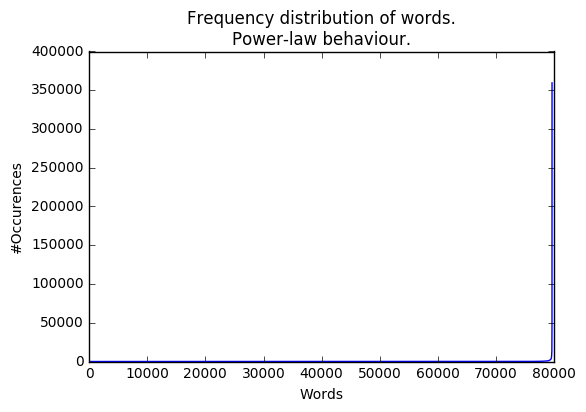

In [256]:
# Frequency distribution of words.

one_doc = []
for doc in docs:
    one_doc.extend(doc)

bow = dictionary.doc2bow(one_doc)
word_freq = [cnt for _, cnt in bow]

plt.plot(sorted(word_freq))
plt.xlabel('Words')
plt.ylabel('#Occurences')
plt.title('Frequency distribution of words.\nPower-law behaviour.')
plt.show()

In [257]:
# Remove rare and common tokens.

# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 20
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

dict0 = dictionary[0]  # This sort of "initializes" dictionary.id2token.

In [258]:
# Vectorize data.

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [259]:
print('Number of authors: %d' % len(author2doc))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of authors: 3467
Number of unique tokens: 8640
Number of documents: 1740


### Disjoint set stuff

In [260]:
def find_disjoint_sets(d):
    while True:
        for tuple_, set1 in d.items():
            try:
                match = next(k for k, set2 in d.items() if k != tuple_ and set1 & set2)
            except StopIteration:
                # no match for this key - keep looking
                continue
            else:
                #print('merging', tuple(set1), match)
                d[tuple_] = set1 | d.pop(match)
                break
        else:
            # no match for any key - we are done!
            break

    output = sorted(tuple(s) for s in d.values())
    
    return output

In [261]:
start = time()

thing = {a: set(_list) for a, _list in author2doc.items()}
disjoint_authors = find_disjoint_sets(thing)
print(disjoint_authors)
print(len(disjoint_authors))

print(time() - start)

[(0,), (1, 27), (2,), (3,), (4,), (5,), (7,), (8,), (9,), (10,), (11, 44, 77, 54), (12,), (15,), (16,), (17,), (18,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (28,), (29,), (30,), (31,), (32,), (33,), (34, 13), (35, 19), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (45,), (46,), (47,), (48,), (49,), (50,), (51,), (52,), (53,), (55,), (56,), (57,), (58,), (59,), (60,), (61,), (62,), (63,), (64,), (65,), (66,), (67,), (68,), (69,), (70,), (71,), (72,), (73,), (74,), (75, 43), (76,), (78,), (79,), (80,), (81,), (82, 14, 6), (83,), (84,), (85,), (86,), (87,), (88,), (89,), (90,), (92,), (94,), (95,), (96,), (97,), (98,), (100,), (102,), (103,), (104,), (105,), (106,), (107, 166), (108,), (109,), (110,), (111,), (112,), (113,), (114,), (115,), (116,), (117,), (118,), (119,), (120, 93), (121, 148), (122,), (123,), (124,), (125,), (126,), (127,), (128, 162, 99, 163, 101, 150), (129,), (130,), (131,), (133,), (134,), (135,), (136,), (137,), (138,), (139, 181), (140,), (141,), (142,

## Online AT VB

In [38]:
%time lda = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary.id2token, passes=10, \
               iterations=100, alpha='auto', eta='symmetric', random_state=1)
var_lambda = lda.state.get_lambda()

CPU times: user 13.6 s, sys: 16 ms, total: 13.6 s
Wall time: 13.6 s


In [98]:
reload(onlineatvb)
OnlineAtVb = onlineatvb.OnlineAtVb

In [138]:
%time model_online = OnlineAtVb(corpus=corpus, num_topics=10, id2word=dictionary.id2token, id2author=id2author, \
                   author2doc=author2doc, doc2author=doc2author, threshold=1e-10, \
                   iterations=10, passes=10, alpha=None, eta=None, decay=0.5, offset=1.0, \
                   eval_every=1000, random_state=1, var_lambda=None)

CPU times: user 2min 35s, sys: 0 ns, total: 2min 35s
Wall time: 2min 35s


In [139]:
model_online.show_topics()

[(0,
  '0.041*training + 0.040*hidden + 0.037*representation + 0.024*role + 0.023*gradient + 0.021*hidden_unit + 0.021*procedure + 0.020*back_propagation + 0.020*node + 0.018*connectionist'),
 (1,
  '0.039*differential + 0.035*search + 0.031*strategy + 0.023*control + 0.020*he + 0.018*goal + 0.017*target + 0.015*start + 0.014*question + 0.014*influence'),
 (2,
  '0.062*code + 0.056*node + 0.051*activation + 0.044*adaptive + 0.029*sequence + 0.022*update + 0.022*learned + 0.014*past + 0.013*summation + 0.013*machine'),
 (3,
  '0.070*cell + 0.043*stimulus + 0.030*synapsis + 0.030*current + 0.029*firing + 0.028*activity + 0.023*synaptic + 0.022*spatial + 0.019*classification + 0.015*channel'),
 (4,
  '0.047*processor + 0.037*dynamic + 0.035*interconnection + 0.032*group + 0.029*iv + 0.023*temporal + 0.022*delay + 0.019*learning_rule + 0.018*vol + 0.017*sigmoid'),
 (5,
  '0.058*image + 0.025*convergence + 0.025*energy + 0.024*matrix + 0.018*hopfield + 0.018*minimum + 0.015*recall + 0.015*r

In [122]:
name = 'Yaser S.Abu-Mostafa'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model_online.get_author_topics(author2id[name]))

name = 'Geoffrey E. Hinton'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model_online.get_author_topics(author2id[name]))

name = 'Michael I. Jordan'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model_online.get_author_topics(author2id[name]))

name = 'James M. Bower'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model_online.get_author_topics(author2id[name]))


Yaser S.Abu-Mostafa
Docs: [21]
[(0, 0.43981727821822292),
 (1, 0.028347213089721844),
 (3, 0.096034791617892343),
 (5, 0.11974213992896583),
 (6, 0.04818530676877044),
 (7, 0.052015356949023761),
 (8, 0.19358105735922765),
 (9, 0.012210592598702002)]

Geoffrey E. Hinton
Docs: [276, 235, 270]
[(0, 0.23709584775467316),
 (1, 0.036278840277891584),
 (2, 0.060881928460912567),
 (3, 0.040860020890840953),
 (4, 0.22120874865101597),
 (5, 0.17881352536707981),
 (6, 0.011552682298532534),
 (7, 0.17862704317305195),
 (8, 0.034587306660400441)]

Michael I. Jordan
Docs: [205]
[(0, 0.2657244791505019),
 (1, 0.042233864299392278),
 (2, 0.056208047768936259),
 (3, 0.020408371858599395),
 (4, 0.075285256015344873),
 (5, 0.44939042793717449),
 (7, 0.064270462578477641),
 (8, 0.014524432524677481),
 (9, 0.011664709291004252)]

James M. Bower
Docs: [188, 251, 244]
[(0, 0.35369888348382267),
 (1, 0.097782509316364244),
 (2, 0.11873783156273017),
 (3, 0.02244484445927224),
 (5, 0.11510615687752906),
 (6,

### Test on a small dataset

In [36]:
n_docs = 10

from copy import deepcopy

small_doc2author = deepcopy(dict(list(doc2author.items())[:n_docs]))
small_doc2author = dict(small_doc2author)

small_corpus = corpus[:n_docs]

In [37]:
authors_ids = set()
for d, a_doc_ids in small_doc2author.items():
    for a in a_doc_ids:
        authors_ids.add(a)

authors_ids = list(authors_ids)
author_id_dict = dict(zip(authors_ids, range(len(authors_ids))))

In [38]:
for d, a_ids in small_doc2author.items():
    for i, a in enumerate(a_ids):
        small_doc2author[d][i] = author_id_dict[a]

In [39]:
# Make a mapping from author IDs to document IDs.
small_author2doc = {}
for a in range(len(author_id_dict)):
    small_author2doc[a] = []
    for d, a_ids in small_doc2author.items():
        if a in a_ids:
            small_author2doc[a].append(d)

In [40]:

author_id_dict_rev = dict(zip(range(len(authors_ids)), authors_ids))

small_id2author = {}
for a, a_id in author_id_dict_rev.items():
    small_id2author[a] = id2author[a_id]

In [41]:
print('phi is %d x %d x %d (%d elements)' %(len(small_corpus), len(dictionary.id2token), 10,
                                            len(small_corpus) * len(dictionary.id2token) * 10))
print('mu is %d x %d x %d (%d elements)' %(len(small_corpus), len(dictionary.id2token), len(small_author2doc),
                                            len(small_corpus) * len(dictionary.id2token) * len(small_author2doc)))

phi is 10 x 681 x 10 (68100 elements)
mu is 10 x 681 x 22 (149820 elements)


In [42]:
reload(onlineatvb)
OnlineAtVb = onlineatvb.OnlineAtVb

In [43]:
%time model = OnlineAtVb(corpus=small_corpus, num_topics=10, id2word=dictionary.id2token, id2author=small_id2author, \
                   author2doc=small_author2doc, doc2author=small_doc2author, threshold=1e-3, \
                   iterations=10, passes=5, alpha=None, eta=None, decay=0.5, offset=1.0, \
                   eval_every=1, random_state=1, var_lambda=None)

CPU times: user 16.5 s, sys: 4 ms, total: 16.5 s
Wall time: 16.5 s


In [133]:
name = 'Amir F.Atiya'
print('\n%s' % name)
print('Docs:', model.author2doc[model.author2id[name]])
pprint(model.get_author_topics(model.author2id[name]))

name = 'FrankWilczek'
print('\n%s' % name)
print('Docs:', model.author2doc[model.author2id[name]])
pprint(model.get_author_topics(model.author2id[name]))



Amir F.Atiya
Docs: [5]
[(0, 0.26236663424329809),
 (1, 0.055837758145413023),
 (2, 0.32385947243135804),
 (4, 0.031231118362347546),
 (5, 0.049702348068489471),
 (6, 0.063277167602715914),
 (7, 0.11515798924424819),
 (9, 0.098115022122885684)]

FrankWilczek
Docs: [1]
[(0, 0.21018310687516228),
 (1, 0.39886126379385306),
 (2, 0.18071281961456737),
 (3, 0.052218386110533886),
 (5, 0.039636353968810233),
 (8, 0.032375816267307712),
 (9, 0.073725725628590477)]


## "Offline" AT VB

In [356]:
print('phi is %d x %d x %d (%d elements)' %(len(corpus), len(dictionary.id2token), 10,
                                            len(corpus) * len(dictionary.id2token) * 10))
print('mu is %d x %d x %d (%d elements)' %(len(corpus), len(dictionary.id2token), len(author2doc),
                                            len(corpus) * len(dictionary.id2token) * len(author2doc)))

phi is 286 x 2245 x 10 (6420700 elements)
mu is 286 x 2245 x 578 (371116460 elements)


In [238]:
%time lda = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary.id2token, passes=10, \
               iterations=100, alpha='auto', eta='symmetric', random_state=1)
var_lambda = lda.state.get_lambda()

CPU times: user 7.81 s, sys: 0 ns, total: 7.81 s
Wall time: 7.81 s


In [140]:
reload(atvb)
AtVb = atvb.AtVb

In [144]:
%time model_offline = AtVb(corpus=corpus, num_topics=10, id2word=dictionary.id2token, id2author=id2author, \
                   author2doc=author2doc, doc2author=doc2author, threshold=1e-12, \
                   iterations=10, alpha='symmetric', eta='symmetric', var_lambda=None, \
                   eval_every=10, random_state=1)

CPU times: user 1min 19s, sys: 28 ms, total: 1min 19s
Wall time: 1min 20s


In [143]:
model_offline.show_topics()

[(0,
  '0.017*cell + 0.008*activity + 0.008*training + 0.007*matrix + 0.007*field + 0.007*representation + 0.006*hopfield + 0.006*probability + 0.006*stimulus + 0.006*current'),
 (1,
  '0.015*cell + 0.009*matrix + 0.007*probability + 0.007*hopfield + 0.007*training + 0.006*activity + 0.006*feature + 0.006*stimulus + 0.006*hidden + 0.005*representation'),
 (2,
  '0.015*cell + 0.008*matrix + 0.008*training + 0.007*representation + 0.006*image + 0.006*field + 0.006*dynamic + 0.006*probability + 0.006*activity + 0.006*sequence'),
 (3,
  '0.013*cell + 0.009*training + 0.007*activity + 0.006*hidden + 0.006*node + 0.005*matrix + 0.005*probability + 0.005*hopfield + 0.005*representation + 0.005*sequence'),
 (4,
  '0.016*cell + 0.007*activity + 0.007*training + 0.007*matrix + 0.007*representation + 0.006*hidden + 0.006*feature + 0.006*synaptic + 0.006*rate + 0.005*field'),
 (5,
  '0.015*cell + 0.008*training + 0.006*matrix + 0.006*sequence + 0.006*field + 0.006*bit + 0.006*stimulus + 0.006*hopf

In [142]:
model.show_topics()

[(0,
  '0.015*dynamic + 0.014*delay + 0.012*frequency + 0.011*phase + 0.010*noise + 0.008*temporal + 0.007*filter + 0.007*oscillation + 0.007*target + 0.007*controller'),
 (1,
  '0.017*memory + 0.017*vector + 0.015*matrix + 0.013*hopfield + 0.011*probability + 0.008*capacity + 0.008*let + 0.008*fig + 0.007*code + 0.007*distribution'),
 (2,
  '0.035*cell + 0.018*response + 0.012*region + 0.012*stimulus + 0.011*cortex + 0.009*fig + 0.009*sensory + 0.009*motor + 0.009*control + 0.009*velocity'),
 (3,
  '0.041*image + 0.038*field + 0.023*visual + 0.016*map + 0.015*receptive + 0.014*receptive_field + 0.014*motion + 0.012*eye + 0.011*direction + 0.008*vision'),
 (4,
  '0.030*hidden + 0.017*hidden_unit + 0.016*activation + 0.012*propagation + 0.010*processor + 0.009*back_propagation + 0.008*gradient + 0.007*hidden_layer + 0.007*bit + 0.006*internal'),
 (5,
  '0.018*vector + 0.016*sequence + 0.016*object + 0.014*memory + 0.009*adaptive + 0.009*matrix + 0.008*recurrent + 0.008*action + 0.008*se

In [119]:
name = 'Yaser S.Abu-Mostafa'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model.get_author_topics(author2id[name]))

name = 'Geoffrey E. Hinton'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model.get_author_topics(author2id[name]))

name = 'Michael I. Jordan'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model.get_author_topics(author2id[name]))

name = 'James M. Bower'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model.get_author_topics(author2id[name]))


Yaser S.Abu-Mostafa
Docs: [21]
[(0, 0.13509546636836239),
 (1, 0.44987514305413251),
 (3, 0.015628876899866424),
 (4, 0.17133899219205551),
 (5, 0.12622125049769653),
 (7, 0.038299020391926251),
 (8, 0.060545623938452663)]

Geoffrey E. Hinton
Docs: [276, 235, 270]
[(0, 0.051128741737399293),
 (2, 0.031947903095827117),
 (3, 0.12717064775550488),
 (4, 0.14970319940657217),
 (5, 0.22650616321963829),
 (6, 0.27680468289365207),
 (7, 0.13302071076542252)]

Michael I. Jordan
Docs: [205]
[(0, 0.62535055104859583),
 (4, 0.087850011456332838),
 (5, 0.18252069201813775),
 (7, 0.094925833198552231)]

James M. Bower
Docs: [188, 251, 244]
[(0, 0.066667129031022732),
 (1, 0.01033213561317742),
 (2, 0.60401298021861427),
 (3, 0.073436683842966574),
 (4, 0.024716090603344801),
 (8, 0.023197011324340159),
 (9, 0.19741318615356793)]


In [31]:
model.show_topics()

[(0,
  '0.019*cell + 0.008*matrix + 0.008*representation + 0.008*training + 0.007*activity + 0.007*node + 0.006*dynamic + 0.006*field + 0.006*probability + 0.005*hopfield'),
 (1,
  '0.016*cell + 0.007*matrix + 0.007*capacity + 0.006*feature + 0.006*activity + 0.006*node + 0.006*field + 0.006*dynamic + 0.006*training + 0.006*stimulus'),
 (2,
  '0.012*cell + 0.010*training + 0.008*matrix + 0.007*stimulus + 0.007*hopfield + 0.006*image + 0.006*noise + 0.006*representation + 0.006*hidden + 0.006*convergence'),
 (3,
  '0.011*cell + 0.008*hopfield + 0.007*activity + 0.007*rate + 0.006*matrix + 0.006*hidden + 0.006*field + 0.006*training + 0.005*node + 0.005*representation'),
 (4,
  '0.012*cell + 0.008*activity + 0.007*matrix + 0.007*training + 0.006*field + 0.006*code + 0.006*representation + 0.006*firing + 0.006*current + 0.005*synaptic'),
 (5,
  '0.014*cell + 0.008*hidden + 0.007*sequence + 0.007*training + 0.006*field + 0.006*noise + 0.006*node + 0.006*dynamic + 0.006*hopfield + 0.006*rep

In [118]:
name = 'Yaser S.Abu-Mostafa'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model.get_author_topics(author2id[name]))

name = 'Geoffrey E. Hinton'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model.get_author_topics(author2id[name]))

name = 'Michael I. Jordan'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model.get_author_topics(author2id[name]))

name = 'James M. Bower'
print('\n%s' % name)
print('Docs:', author2doc[author2id[name]])
pprint(model.get_author_topics(author2id[name]))


Yaser S.Abu-Mostafa
Docs: [21]
[(0, 0.090225715808980797),
 (1, 0.014047723409152875),
 (3, 0.38971799227229242),
 (4, 0.30695125800680684),
 (5, 0.11680215128570454),
 (7, 0.012641840087616362),
 (8, 0.069095036605336377)]

Geoffrey E. Hinton
Docs: [276, 235, 270]
[(0, 0.17326190127690461),
 (2, 0.062709625689712375),
 (3, 0.023215349136065065),
 (4, 0.096803072840719678),
 (5, 0.1267901905748583),
 (6, 0.47635551675437715),
 (7, 0.025581291656655011),
 (9, 0.013530262666658776)]

Michael I. Jordan
Docs: [205]
[(0, 0.22189029162114421),
 (2, 0.033072831647105602),
 (4, 0.051509519512663651),
 (5, 0.63361728214218349),
 (7, 0.045992411979857574),
 (9, 0.012757930948596466)]

James M. Bower
Docs: [188, 251, 244]
[(1, 0.29194178492747924),
 (2, 0.47740737076112999),
 (3, 0.023636461735819542),
 (4, 0.010413505064807139),
 (7, 0.018554608959817139),
 (9, 0.17063597622983562)]


### Test on small corpus

In [30]:
lda = LdaModel(corpus=small_corpus, num_topics=10, id2word=dictionary.id2token, passes=10)
var_lambda = lda.state.get_lambda()

In [44]:
reload(atvb)
AtVb = atvb.AtVb

In [45]:
%time model = AtVb(corpus=small_corpus, num_topics=10, id2word=dictionary.id2token, id2author=small_id2author, \
                   author2doc=small_author2doc, doc2author=small_doc2author, threshold=1e-12, \
                   iterations=5, alpha='symmetric', eta='symmetric', \
                   eval_every=1, random_state=1, var_lambda=None)

CPU times: user 8.61 s, sys: 4 ms, total: 8.61 s
Wall time: 8.62 s


In [34]:
model.show_topics()

[(0,
  '0.071*group + 0.039*matrix + 0.032*feedback + 0.027*whose + 0.018*obtain + 0.016*scheme + 0.015*constraint + 0.015*expression + 0.014*unique + 0.013*computational'),
 (1,
  '0.041*map + 0.040*field + 0.034*location + 0.033*brain + 0.030*node + 0.021*requires + 0.020*propagation + 0.016*back_propagation + 0.016*distribution + 0.014*mechanism'),
 (2,
  '0.084*processor + 0.075*edge + 0.052*activation + 0.034*update + 0.021*column + 0.020*run + 0.019*implementation + 0.018*control + 0.018*operation + 0.017*content'),
 (3,
  '0.046*image + 0.038*gradient + 0.027*flow + 0.025*field + 0.024*analog + 0.023*circuit + 0.022*constraint + 0.018*square + 0.017*vision + 0.017*technique'),
 (4,
  '0.023*dynamic + 0.021*phase + 0.018*cell + 0.018*variable + 0.017*with_respect + 0.017*respect + 0.016*path + 0.015*noise + 0.014*energy + 0.011*limit'),
 (5,
  '0.080*processor + 0.061*activation + 0.040*edge + 0.040*update + 0.021*store + 0.020*operation + 0.018*required + 0.018*address + 0.017*s

In [35]:
model.get_author_topics(0)

[(0, 0.55485121572041607),
 (4, 0.17897884328936686),
 (6, 0.14414251935372879),
 (8, 0.11957893769069983)]

## LDA

In [158]:
reload(gensim.models.ldamodel)
LdaModel = gensim.models.ldamodel.LdaModel

In [151]:
lda = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary.id2token, passes=10,
               iterations=100, alpha='auto', eta='symmetric')

In [154]:
lda.show_topics()

[(0,
  '0.020*memory + 0.015*chip + 0.010*synapse + 0.009*hidden + 0.009*energy + 0.008*activation + 0.008*bit + 0.007*analog + 0.007*associative + 0.007*circuit'),
 (1,
  '0.013*node + 0.010*vector + 0.008*dynamic + 0.007*role + 0.006*matrix + 0.006*temporal + 0.006*sequence + 0.005*propagation + 0.005*action + 0.004*noise'),
 (2,
  '0.022*processor + 0.017*activation + 0.013*cycle + 0.011*path + 0.009*machine + 0.008*cm + 0.007*letter + 0.007*array + 0.006*update + 0.006*string'),
 (3,
  '0.017*node + 0.010*circuit + 0.008*threshold + 0.007*classifier + 0.007*probability + 0.006*distribution + 0.005*bit + 0.005*vector + 0.005*let + 0.004*polynomial'),
 (4,
  '0.017*memory + 0.010*vector + 0.010*fig + 0.009*matrix + 0.009*delay + 0.008*cell + 0.008*cortex + 0.007*associative + 0.007*map + 0.006*dynamic'),
 (5,
  '0.028*cell + 0.010*response + 0.010*firing + 0.009*stimulus + 0.008*activity + 0.007*frequency + 0.007*potential + 0.007*current + 0.006*synaptic + 0.006*spike'),
 (6,
  '0.0

In [59]:
lda[corpus[0]]

[(0, 0.14679045510589872),
 (2, 0.024722847345847499),
 (3, 0.036692535207794273),
 (4, 0.10874558108160597),
 (6, 0.29675634369596471),
 (9, 0.38555538612902118)]